# Entrega Laboratorio: Eliminación de anomalías de la imagen.

## Definición del problema.

#### Trabajar con imágenes o símplemente sacar fotografías de algún rincón que se quiera rememorar no es una tarea sencilla. Generalmente, en las fotografías tomadas al aire libre aparecen invitados no deseados llamados artefactos. Estos artefactos son anomalías en la imagen, y pueden ser provocados por defectos de la propia cámara o por el entorno en el que se realiza la fotografía. Existiendo distintos tipos de artefactos en función del tipo de error que sufre la cámara o las caracterísaticas concretas del entorno.
#### Afortunadamente, se pueden realizar distintas operaciones para la reducción de artefactos mediante el empleo de distintas técnicas, ya sean basadas en operaciones a nivel de pixel o a nivel de todo el histograma.
#### En el presente documento se presenta un programa que soluciona el artefacto denominado Color Cast para una serie de fotografías que sufren dicho artefacto.

## Definición del artefacto a resolver.

#### El artefacto que se ha querido resolver es el conocido como Color Cast y algunas de sus variaciones.

#### Este artefacto es originado por el entorno en el que se toma la imagen, donde la luz ambiente tiñe la imagen de ese color. Esto es frecuente en espacios interiores donde en función del color principal de la luz que emiten las bombillas, la imagen será más cálida o más fria en función de si estas emiten más rojo o azul respectivamente. Este fenómeno provoca que la imagen se envuelva principalmente de ese color y que por tanto, los histográmas de dicho canal de color cuenten con una gran cantidad de pixeles claros.

#### Otro artefacto relacionado con el Color Cast es la sobre/infraexposición que se produce cuando en el momento de tomar la fotografía se captura demasiada o poca luz, lo que hace que la imagen se sature y resulte en zonas demasiado brillantes. Ante estas situaciones, el histograma del canal de color saturado se encuentra volcado a la parte de los colores claros.

## Objetivos 

#### El objetivo del proyecto es la creación de un algoritmo que permita arreglar imagenes en las que aparezca el artefacto Color Cast o artefactos de sobre e infra exposición que hagan que las imagenes sean demasiado claras u oscuras.

#### Para la resolución de este problema se ha realizado en primer lugar un proceso de interpolación para cada canal de color para conseguir un histograma ecualizado. Tal y como se ha dicho, la ecualización se ha realizado para cada canal de color, aunque también se ha planteado realizar una única interpolación del histograma completo en escala de grises o ecualizar únicamente el canal de color más dañado por el artefacto. Sin embargo, debido a que los resultados obtenidos con esos métodos no han sido tan buenos, se ha decidido realizar una interpolación por cada canal de color.

#### Una vez realizada la ecualización, para los casos en los que el resultado no sea el esperado, se realiza un balance de colores aplicando la técnica del autocontraste. La expansión del rango dinámico requerida para aplicar el autocontraste se puede realiza manualmente para cada imagen mediante la variación de los percentiles por canal de color.

#### Además del propio algoritmo que resuelve el problema del Color Cast, se ha creado una aplicación para facilitar la presentación de los resultados. Esta aplicación permite visualizar claramente los efectos de ambos algoritmos, permitiendo ver simultaneamente tanto la imagen como los histogramas previos y posteriores, así como permite modificar in situ los percentiles de cada canal de color para poder "tunear" el autocontraste al gusto.


#### A continuación se presenta el código empleado para cumplir los objetivos. Para cada función y paso realizado se da una explicación de su función.

# 1. Preparación del entorno

## 1.1. Importar librerias


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from typing import Tuple

import cv2

from skimage import img_as_ubyte, img_as_float
from skimage.io import imread, imshow, imsave
from skimage.exposure import histogram, cumulative_distribution

from scipy.stats import norm

## 1.2. Cargar imagenes

In [2]:
images_path = []
images = []

# Itera la carpeta input y carga todas las imagenes que se encuentran en esta.
# Guarda su ruta por si es necesaria en alguna operación posterior.
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        images_path.append(os.path.join(dirname, filename))
        images.append(imread(os.path.join(dirname, filename)))
        print(os.path.join(dirname, filename))

./input\Si_1.jpg
./input\Sí_2.jpg
./input\Sí_3.jpg
./input\Sí_4.jpg
./input\Sí_5.jpg


# 2. Artefacto

## 2.1. Descripción imagen.

In [34]:
class Exploracion:
    
    def __init__(self):
        print("USTED FUE HACKIADO caritaFachera")
    
    def descripcion_colores(self, filename, leer=True):
        """
        # TODO Documentación
        """
        # Si se pasa la ruta lee imagen, sino toma "filename" como imagen
        if leer:
            img = plt.imread(filename)
        else:
            img = filename
        
        # Lista vacia para almacenar valores
        df_color = []
        
        # Para cada color, calcula una serie de datos estadisticos que permitan como se conforma la imagen.
        for canal in range(0, 3):
            min_color = np.min(img[:,:,canal])
            max_color =np.max(img[:,:,canal]) # Maximo rango dinamico por canal de color
            mean_color = round(np.mean(img[:,:,canal])) # Media de color por cada rango
            median_color = round(np.median(img[:,:,canal])) # Mediana de color por cada rango (representa el valor de la variable de posición central en un conjunto de datos ordenados.)
            std_color = round(img[:,:,canal].std())
            sum_color = round(img[:,:,canal].sum())
            # Calcula percentiles. Por ejemplo: el percentil 90 es el valor en el cual 90 porciento de las intensidades son inferiores.
            perc_01 = np.percentile(img[:,:,canal], 1, axis=(0,1))
            perc_05 = np.percentile(img[:,:,canal], 5, axis=(0,1))
            perc_10 = np.percentile(img[:,:,canal], 10, axis=(0,1))
            perc_90 = np.percentile(img[:,:,canal], 90, axis=(0,1)) 
            perc_95 = np.percentile(img[:,:,canal], 95, axis=(0,1))
            perc_99 = np.percentile(img[:,:,canal], 99, axis=(0,1))

            # Añade los datos a un dataframe.
            row = (min_color,max_color, mean_color, median_color, std_color, sum_color, 
                   perc_01, perc_05, perc_10, perc_90, perc_95, perc_99)     
            df_color.append(row)

        return pd.DataFrame(df_color, 
                            index = ['Red', ' Green', 'Blue'],
                            columns = ['Min','Max', 'Mean', 'Median',"Std","Sum",
                                    "P_01","P_05","P_10",'P_90',' P_95', 'P_99'])
    
    def comparación_distribucion_acumulada(self, ruta_imagen, leer=True):
        """
        # TODO Rehacer documentacion
        Calcula la Distribucion de probabilidad acumulada de una variable, donde x toma el valor de menor o igual a x
        F(x) = P(X <= X). Para el calculo, no es posible de momento la realizacion de dicha integral, se calcula numericamente
        y tiene una forma aproximada de una recta. Ya que intentar balancear los pixeles a una distribución normal es complicado,
        se utilizará la distribución acumulativa e interpolaremos los canales a esta.
        """
        
        # Si se pasa la ruta lee imagen, sino toma "filename" como imagen
        if leer:
            img = plt.imread(ruta_imagen) # Leo la imagen
        else:
            img = ruta_imagen
        
        # Retorna la funcion de distribucion acumulada por canal. # En este caso un lista de y-> probabilidad acumulada,
        # x-> valor de color del pixel, por tanto devuelve un array de 3x2, 3 canales, eje y y eje x
        freq_bins = [cumulative_distribution(img[:,:,i]) for i in range(3)] 
        # Bins para el eje x para todos los valores de intensidad.                                                                    
        target_bins = np.arange(255)                    
        # Retorna un array de 0 a 1, 255 elementos
        target_freq = np.linspace(0, 1, len(target_bins)) 
        # Titulos para lo distintos plots.
        names = ['Red', 'Green', 'Blue']
        # Colores de las lineas en el grafico.
        line_color = ['red','green','blue']
        f_size = 20
        # Crea figura
        fig, ax = plt.subplots(1, 3, figsize=(17,5))
        
        # Añade histogramas acumulados a la figura
        for n, ax in enumerate(ax.flatten()): # array 1d
            ax.set_title(f'{names[n]}', fontsize = f_size)
            ax.step(freq_bins[n][1], freq_bins[n][0], c=line_color[n],label='Actual FDA') # Eje x -> [n][1] valores de 0-255; eje y -> [n][0]
            ax.plot(target_bins, target_freq, c='gray', label='Target CDF', linestyle = '--')
            
    def acumulativo_histo(self, filename, leer=True):
        """
        TODO
        """
        # Si se pasa la ruta lee imagen, sino toma "ruta_imagen" como imagen
        if leer:
            img = plt.imread(filename) # Leo la imagen
        else:
            img = filename
        
        # Crea histogramas de los distintos colores
        new_hist_R, _ = np.histogram(img[:,:,0].ravel(),256,[0,256]) 
        new_hist_G, _ = np.histogram(img[:,:,1].ravel(),256,[0,256]) 
        new_hist_B, _ = np.histogram(img[:,:,2].ravel(),256,[0,256]) 

        # Calcula el valor acumulado
        new_cdf_R = new_hist_R.cumsum()
        new_cdf_G = new_hist_G.cumsum()
        new_cdf_B = new_hist_B.cumsum()
        
        # Crea figura
        f, axarr = plt.subplots(nrows=1,ncols=3, figsize=(18,5))
        # Representa en cada subplot
        plt.sca(axarr[0]); 
        plt.plot(new_cdf_R, color='r'); plt.title('Red')
        plt.sca(axarr[1]); 
        plt.plot(new_cdf_G, color='g'); plt.title('Green')
        plt.sca(axarr[2]); 
        plt.plot(new_cdf_B, color='b'); plt.title('Blue')
        plt.show()
              
    def gris_histo(self, filename, read=True):
        """
        # TODO Hacer documentacion
        """
        # Si se pasa la ruta lee imagen, sino toma "filename" como imagen
        if leer:
            img = plt.imread(filename) # Leo la imagen
        else:
            img = filename
            
        # Crea un histograma a partir de la imagen
        hist = cv2.calcHist([img],[0],None,[256],[0,256])
        # Crea el gráfico
        plt.title("Gray Image Histogram")
        plt.xlabel("Bins")
        plt.ylabel("Number of Pixels")
        plt.plot(hist)
        # Muestra el grafico.
        plt.show()
        
        
    def color_histo(self, filename, read=True):
        """
        # TODO Hacer documentación
        """
        # Si se pasa la ruta lee imagen, sino toma "filename" como imagen
        if read:
            img = plt.imread(filename) # Leo la imagen
        else:
            img = filename
        # Crea una figura con 3 plots, uno para  cada canal.
        f, axarr = plt.subplots(nrows=1,ncols=3, figsize=(18,5))
        plt.sca(axarr[0]); 
        plt.hist(img[:,:,0].ravel(),256,[0,256], color='r'); plt.title('Red')
        plt.sca(axarr[1]); 
        plt.hist(img[:,:,1].ravel(),256,[0,256], color='g') ; plt.title('Green')
        plt.sca(axarr[2]); 
        plt.hist(img[:,:,2].ravel(),256,[0,256], color='b') ; plt.title('Blue')
        plt.show()
        
    def comparar_histo(self, filename, read=True):
        """
        # TODO Hacer documentación
        """
        # Si se pasa la ruta lee imagen, sino toma "filename" como imagen
        if leer:
            img = plt.imread(filename) # Leo la imagen
        else:
            img = filename
        # Dividir canales segun COLORES ^^   
        channels = cv2.split(img)       
        colors = ("r", "g", "b")        
        plt.figure()    
        plt.title("Color Histogram")
        plt.xlabel("Bins")
        plt.ylabel("Number of Pixels")
        for (i, col) in zip(channels, colors):      
            hist = cv2.calcHist([i], [0], None, [256], [0, 256]) 
            plt.plot(hist, color = col)   
            plt.xlim([0, 256])
        plt.show()
        


# 3. Ajuste de imagen.




In [55]:
class Contrast:

    def __init__(self):
        print("CONTRAST LOADED")
    
    def compute_cdfs(self, data_R: np.ndarray, data_G: np.ndarray, data_B: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Computes the cumulative distribution functions for each channel
        
        Parameters
        ----------
        data_R : ndarray
            Red channel data
        data_G : ndarray
            Green channel data
        data_B : ndarray
            Blue channel data
            
        Returns
        -------
        cdf_R, cdf_B, cdf_G : ndarray
            Cumulative distribution functions for each channel
        """
        hist_R, _ = np.histogram(data_R.flatten(), 256, [0, 256]) 
        hist_G, _ = np.histogram(data_G.flatten(), 256, [0, 256]) 
        hist_B, _ = np.histogram(data_B.flatten(), 256, [0, 256]) 
        
        cdf_R, cdf_G, cdf_B = hist_R.cumsum(), hist_G.cumsum(), hist_B.cumsum()
        
        return cdf_R, cdf_G, cdf_B

    def search_limits(self, cdf: np.ndarray, low_saturation: float, high_saturation: float) -> Tuple[int, int]:
        """
        Computes the low and high limits using quantiles.
        
        Parameters
        ----------
        cdf : ndarray
            Cumulative distribution function
        low_saturation : float
            Saturation to compute the low limit
        high_saturation : float
            Saturation to compute the high limit
            
        Returns
        -------
        low_limit, high_limit : Tuple[int, int]
            Low and high limits
        """
        size = cdf.max()
        
        minimum = (cdf <= size * low_saturation)
        maximum = (cdf >= size * (1 - high_saturation))
        
        return np.argmin(minimum), np.argmax(maximum)

    def autocontrast(self, pixel: int, a_low: int, a_high: int) -> int:
        """
        Performs the autocontrast technique in a given pixel intensity

        Parameters
        ----------
        pixel : int
            Pixel intensity
        a_low : int
            Lowest intensity possible
        a_high : int
            Highest intensity possible  
        
        Returns
        -------
        int
            Intensity mapped to the new range
        """
        if pixel <= a_low:
            return 0
        elif a_low < pixel < a_high:
            numerator = (pixel - a_low) * 255
            denominator = a_high - a_low
            
            return numerator / denominator
        else:
            return 255

    def create_new_RGB_image(self, shape: Tuple[int, int, int], data_R: np.ndarray, data_G: np.ndarray, data_B: np.ndarray) -> np.ndarray:
        """
        Creates a new image
        
        Parameters
        ----------
        shape : Tuple[int, int]
            Shape of the new image
        data_R : ndarray
            Red channel data
        data_G : ndarray
            Green channel data
        data_B : ndarray
            Blue channel data
            
        Returns
        -------
        new_img : ndarray
            New RGB image
        """
        new_img = np.zeros(shape).astype(np.uint8) # En el collab sale image.shape
        new_img[:, :, 0], new_img[:, :, 1], new_img[:, :, 2] = data_R, data_G, data_B
        
        return new_img

    def color_balance_RGB_image(self, image_data: np.ndarray, red_saturation_low: float, red_saturation_high: float,
                                green_saturation_low: float, green_saturation_high: float,
                                blue_saturation_low: float, blue_saturation_high: float) -> np.ndarray:
        """
        Performs color balancing on a given image

        Parameters
        ----------
        image_data : ndarray
            Array containing the image data
        saturation : float
            Saturation ratio

        Returns
        -------
        new_image : ndarray
            Color balanced image
        """
        if len(image_data.shape) != 3 or image_data.shape[2] != 3:
            raise ValueError('It is not an RGB image')

        # Gets the data from each channel
        data_R, data_G, data_B = image_data[:, :, 0], image_data[:, :, 1], image_data[:, :, 2]

        # Generated the cumulative distribution function for each channel
        cdf_R, cdf_G, cdf_B = self.compute_cdfs(data_R, data_G, data_B)

        # Computes the low and high limits for each channel
        low_limit_R, high_limit_R = self.search_limits(cdf_R, red_saturation_low, red_saturation_high)
        low_limit_G, high_limit_G = self.search_limits(cdf_G, green_saturation_low, green_saturation_high)
        low_limit_B, high_limit_B = self.search_limits(cdf_B, blue_saturation_low, blue_saturation_high)

        # Apply the autocontrast transformation to each channel
        new_data_R = np.vectorize(self.autocontrast)(data_R, low_limit_R, high_limit_R)
        new_data_G = np.vectorize(self.autocontrast)(data_G, low_limit_G, high_limit_G)
        new_data_B = np.vectorize(self.autocontrast)(data_B, low_limit_B, high_limit_B)

        # Creates the new image
        new_image = self.create_new_RGB_image(image_data.shape, new_data_R, new_data_G, new_data_B)

        return new_image
    
    def normalize(self, pixel, min, max, max_intensity):
        numerator = (pixel - min) * max_intensity
        denominator = max - min

        return (numerator / denominator)
    
    def rgb_adjuster_lin(self, image, plot=True, read=True):
    
        if read:
            img = plt.imread(image)
        else:
            img = image


        # Corregir rango dinamico, no hay rango de 255 distintos :( (min-max)
        ceros = np.zeros(img.shape)
        ceros[:,:,0] = (np.vectorize(self.normalize)(img[:,:,0],img[:,:,0].min(),img[:,:,0].max(),255))
        ceros[:,:,1] = (np.vectorize(self.normalize)(img[:,:,1],img[:,:,1].min(),img[:,:,1].max(),255))
        ceros[:,:,2] = (np.vectorize(self.normalize)(img[:,:,2],img[:,:,2].min(),img[:,:,2].max(),255))

        img = ceros.astype(np.uint8)

        target_bins = np.arange(255)
        target_freq = np.linspace(0, 1, len(target_bins))
        freq_bins = [cumulative_distribution(img[:,:,i]) for i in range(3)]
        names = ['Reds', 'Greens', 'Blues']
        line_color = ['red','green','blue']
        adjusted_figures = []
        f_size = 20

        # Interpolacion y visualizacion de las imagenes
        fig, ax = plt.subplots(1,3, figsize=[15,5])
        for n, ax in enumerate(ax.flatten()):
            # Lo que queremos interpolar son las y, por eso esta al reves, nos da un objeto interpolacion que lo que hacemos es poner lo que queremos interpolar, y los ejes donde queremos sacar dichos puntos
            target_bins = np.arange(0,img[:,:,n].max())
            target_freq = np.linspace(0, 1, len(target_bins))

            interpolation = np.interp(freq_bins[n][0], target_freq, target_bins) # (a,x,y) a->The x-coordinates at which to evaluate the interpolated values. 
            adjusted_image = img_as_ubyte(interpolation[img[:,:,n]].astype(int))
            ax.set_title(f'{names[n]}', fontsize = f_size)
            ax.imshow(adjusted_image, cmap = names[n])
            adjusted_figures.append([adjusted_image])    
        fig.tight_layout() 

        if plot:
            # Creacion de los graficos interpolados
            fig, ax = plt.subplots(1,3, figsize=[15,5])
            for n, ax in enumerate(ax.flatten()):
                interpolation = np.interp(freq_bins[n][0], target_freq, target_bins)
                adjusted_image = img_as_ubyte(interpolation[img[:,:,n]].astype(int))
                freq_adj, bins_adj = cumulative_distribution(adjusted_image)
                ax.set_title(f'{names[n]}', fontsize = f_size)
                ax.step(bins_adj, freq_adj, c=line_color[n], label='Actual CDF')
                ax.plot(target_bins, target_freq, c='gray', label='Target CDF',linestyle = '--')
            fig.tight_layout()
        img_aj = np.dstack((adjusted_figures[0][0],adjusted_figures[1][0],adjusted_figures[2][0]))
        fig, ax = plt.subplots(1,2, figsize=[15,5])
        ax[0].imshow(img)
        ax[1].imshow(np.dstack((adjusted_figures[0][0],adjusted_figures[1][0],adjusted_figures[2][0])));
        
        return img_aj
        # plt.imsave('F_light_6_equalized44.jpg',img_aj)       
        
    def create_balanced(self, filename: str, red_saturation_low:float =0.08, red_saturation_high:float =0.08,
                          green_saturation_low:float =0.08, green_saturation_high:float =0.08,
                          blue_saturation_low:float =0.08, blue_saturation_high:float =0.08, read=True):
                
        if read:
            image = plt.imread(filename)
        else:
            image = filename
        
        return self.color_balance_RGB_image(image, red_saturation_low, red_saturation_high,
                                           green_saturation_low, green_saturation_high,
                                           blue_saturation_low, blue_saturation_high)

## 3.1. Interpolación

In [134]:
exploration.comparacion_distribucion_acumulada(images_path[0])

AttributeError: 'Exploration' object has no attribute 'comparacion_distribucion_acumulada'

CONTRAST LOADED


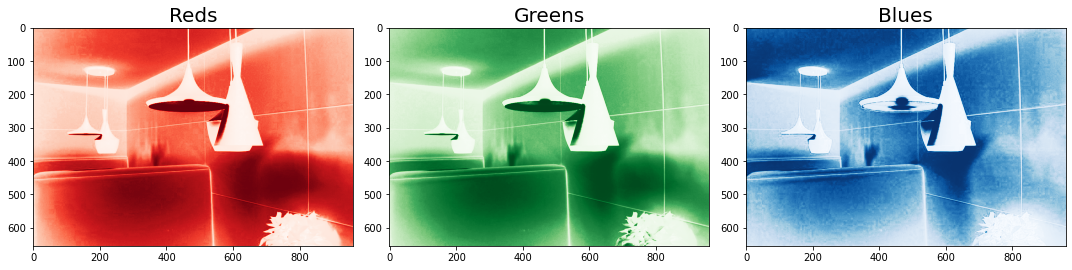

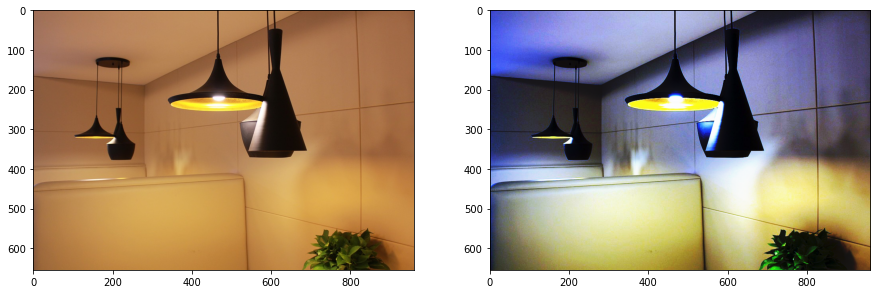

In [156]:
contrast = Contrast()
contrast.rgb_adjuster_lin(images_path[3], plot=False);

## 3.2. Autocontraste


In [35]:
explorer = Exploracion()
contraster = Contrast()

USTED FUE HACKIADO caritaFachera
CONTRAST LOADED


A continuacion vamos a mostrar la imagen a la que se le va a aplicar la técnica del autocontraste. Como se puede observar, esta imagen tiene un tono de luz cálida, por lo que el objetivo del autocontraste es eliminar esta tonalidad y conseguir que la imagen tenga una luz más natural.

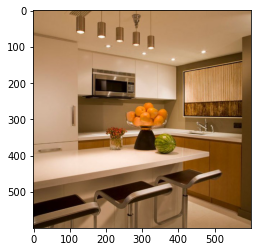

In [36]:
plt.imshow(images[0])

Antes de aplicar el autocontraste vamos a mostrar tanto el histograma como la función de distribución acumulada por cada canal de color (RGB). En los histogramas se puede observar lo reflejado en la imagen, el color azul tiene menos píxeles con intensidades elevadas, al contrario que el color rojo. Esto provoca el efecto de luz cálida comentado anteriormente.

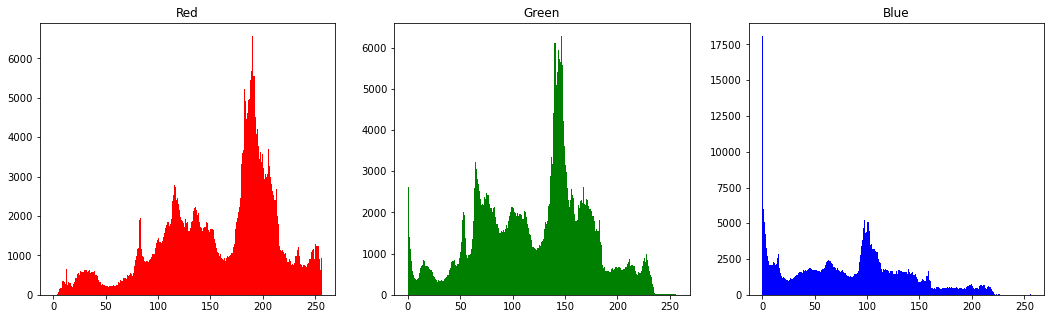

In [39]:
explorer.color_histo(images[0], read=False)

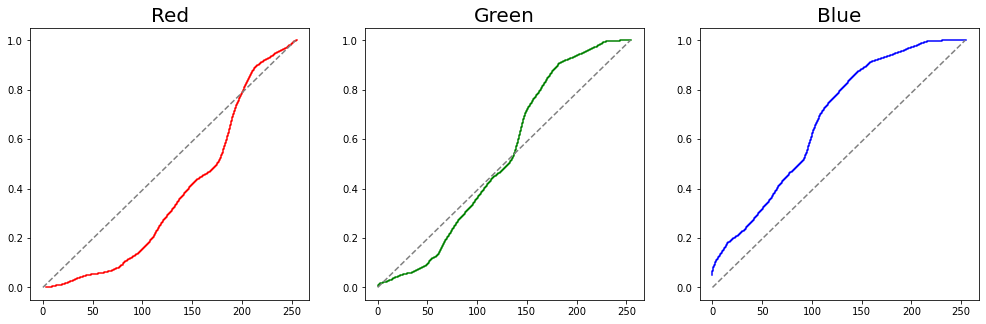

In [37]:
explorer.comparación_distribucion_acumulada(images[0], leer=False)

Para aplicar el autocontraste primero necesitamos calcular las nuevas intensidades máximas y mínimas. Para realizar este cálculo se se han utilizado los cuantiles de la función de distribución acumulada de cada canal y como se muestran a continuación:

$$\large{a_{low} = min\{i|H(i)≥M⋅N⋅s_{low}}\}$$
$$\large{a_{high} = max\{i|H(i)≤M⋅N⋅(1−s_{high})}\}$$

Para la intensidad mínima se eliminará un pequeño porcentaje de los píxeles de intensidades inferiores y se obtendrá la nueva intensidad mínima. De la misma forma, para la intensidad máxima se eliminará un porcentaje de los píxeles con las intensidades más altas y se obtendrá la nueva intensidad máxima.

In [40]:
img_R, img_G, img_B = images[0][:, :, 0], images[0][:, :, 1], images[0][:, :, 2]

In [41]:
cdf_R, cdf_G, cdf_B = contraster.compute_cdfs(img_R, img_G, img_B)

In [60]:
a_low_R, a_high_R = contraster.search_limits(cdf_R, 0.02, 0.02)
a_low_G, a_high_G = contraster.search_limits(cdf_G, 0.01, 0.01)
a_low_B, a_high_B = contraster.search_limits(cdf_B, 0.01, 0.01)

In [61]:
a_low_R, a_high_R

(26, 248)

Eliminando un 2\% por cada lado, la nueva intensidad mínima del color rojo pasa a ser la 26, mientras que la máxima pasa a ser la 248. Esto quiere decir que existía mayor número de píxeles en intensidades altas que en bajas, lo que cuadra con el histograma y la función de distribución acumulada. 

In [62]:
a_low_G, a_high_G

(1, 228)

In [63]:
a_low_B, a_high_B

(0, 213)

De la misma forma que con el canal rojo, con el canal verde los nuevos máximos y mínimos pasan a ser la intensidad 1 y la 228. En el caso del canal azul la intensidad mínima se mantiene en el 0 por lo que eso significa que hay gran número de píxeles en esa intensidad, mientras que la intensidad máxima pasa a ser 213.

Una vez que tenemos el nuevo rango de intensidades para cada canal, debemos realizar el mapeo correspondiente. Para realizar el mapeo utilizaremos la siguiente ecuación:

$$
f(a)=
\large{\begin{cases}
  a_{min} \text{ for }a\leq a_{low}\\    
  a_{min} + (a - a_{low}) \cdot \frac{a_{max} - a_{min}}{a_{high} - a_{low}} \text{ for } a_{low} < a < a_{high}\\
  a_{max} \text{ for }a\geq a_{high}\\ 
\end{cases}}
$$

Si

$$
f(a)=
\large{\begin{cases}
  0 \text{ for }a\leq a_{low}\\    
  0 + (a - a_{low}) \cdot \frac{255}{a_{high} - a_{low}} \text{ for } a_{low} < a < a_{high}\\
  255 \text{ for }a\geq a_{high}\\ 
\end{cases}}
$$

Esta ecuación asignara un 0 para intensidades que caigan por debajo de la nueva intensidad mínima, mientras que para intensidades que sean superiores a la nueva intensidad máxima asignara un 255 (ya que usamos 8 bits). Para las intensidades que caigan entre los valores máximos y mínimos calcula el mapeo de su nuevo valor.

In [64]:
new_data_R = np.vectorize(contraster.autocontrast)(img_R, a_low_R, a_high_R).astype(np.uint8)
new_data_G = np.vectorize(contraster.autocontrast)(img_G, a_low_G, a_high_G).astype(np.uint8)
new_data_B = np.vectorize(contraster.autocontrast)(img_B, a_low_B, a_high_B).astype(np.uint8)

In [65]:
new_data_R.min(), new_data_R.max()

(0, 255)

In [66]:
new_data_G.min(), new_data_G.max()

(0, 255)

In [67]:
new_data_B.min(), new_data_B.max()

(0, 255)

Como se puede observar el mapeo de intensidades ha sido satisfactorio y los nuevos canales de colores vuelven a estar en el rango de $[0-255]$.  
A continuación se va a crear la nueva imagen autocontrastada para ver el resultado.

In [68]:
new_image = contraster.create_new_RGB_image(images[0].shape, new_data_R, new_data_G, new_data_B)

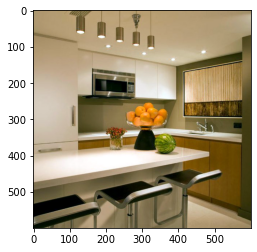

In [69]:
plt.imshow(new_image)

Se puede apreciar que el resultado es satisfactorio, la imagen ya no tiene el efecto de luz cálida. Para finalizar, se va a mostrar tanto el histograma como la función de distribución acumulada de cada canal.

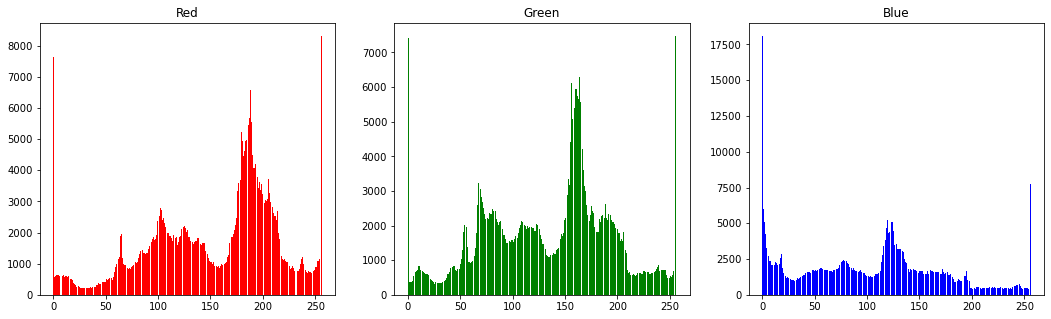

In [58]:
explorer.color_histo(new_image, read=False)

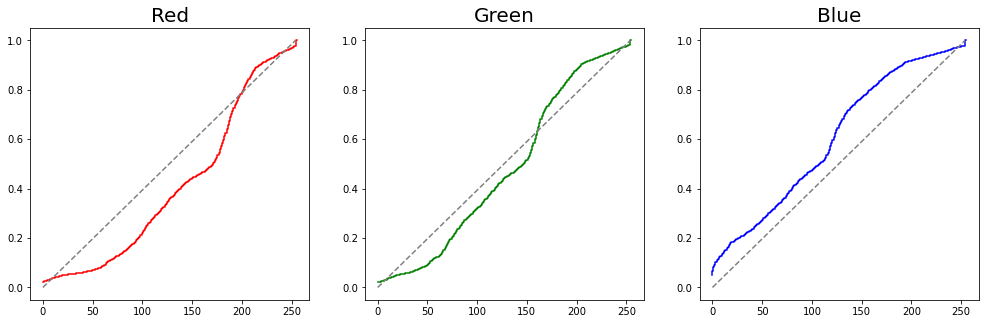

In [59]:
explorer.comparación_distribucion_acumulada(new_image, leer=False)

Los histogramas de cada canal han expandido todo su rango de píxeles al rango $[0-255]$. En el caso de las funciones de distribución acumuladas, la curva se ha aplanado un poco acercándose a la de una distribución uniforme. Dado que esto no es la equalización del histograma, estos resultados son los esperados.

# 4. Resultados
